In [1]:
import sys
sys.path.append('../src/')

from benchmark.tools import *
from benchmark.models import Accuracy, Face, Box, Prediction, ImageFaces
from benchmark.utils import load_aflw
from benchmark.stats import predictions_summary

import tensorflow_datasets as tfds
import wider_dataset

In [2]:
face_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

In [3]:
box_counter = 0

Speed: 244.2547ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


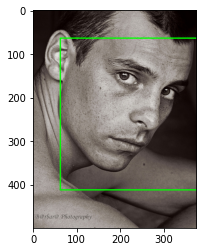

Speed: 10.8238ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


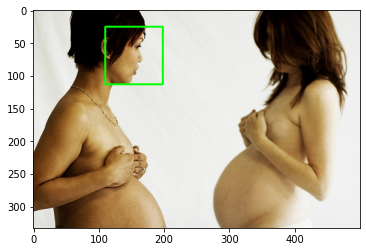

Speed: 20.3832ms
Precision: 1.0
Recall: 1.0
Ious: [0.8197822312547948]
Positives: 1, False Positives: 0, Negatives: 0


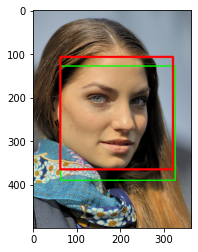

Speed: 63.3769ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 2


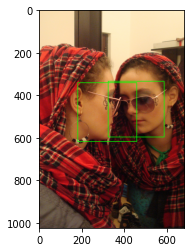

Speed: 32.5676ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


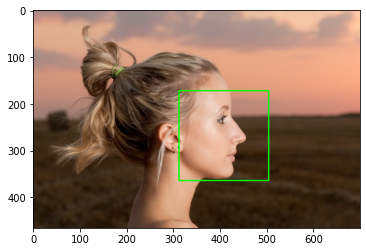

Speed: 18.5522ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


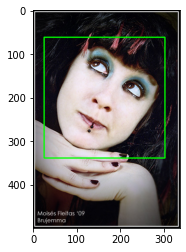

Speed: 16.2242ms
Precision: 1.0
Recall: 1.0
Ious: [0.2554643194706994]
Positives: 1, False Positives: 0, Negatives: 0


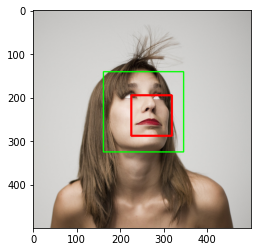

Speed: 15.9859ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


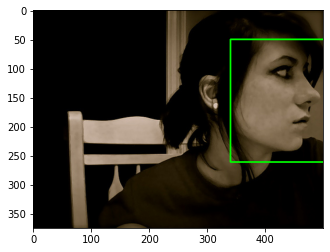

Speed: 19.6347ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


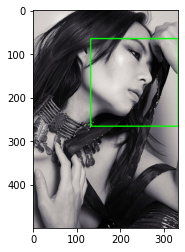

Speed: 62.5591ms
Precision: 0.5
Recall: 1.0
Ious: [0.2800852071005917]
Positives: 1, False Positives: 1, Negatives: 0


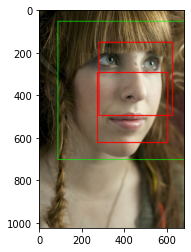

Speed: 19.4552ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


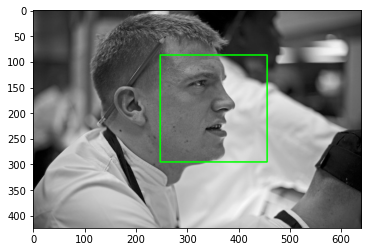

Speed: 298.0516ms
Precision: 0.0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 1, Negatives: 1


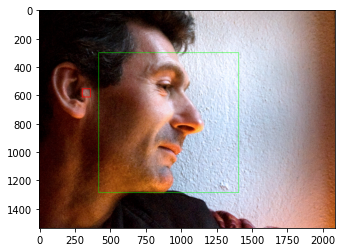

Speed: 46.9399ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


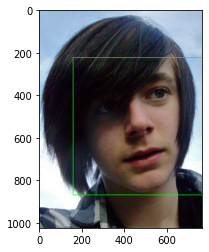

Speed: 27.0708ms
Precision: 0.0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 1, Negatives: 1


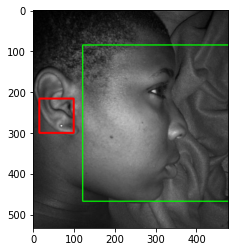

Speed: 17.4268ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


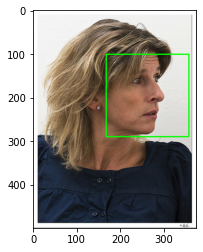

Speed: 34.4051ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


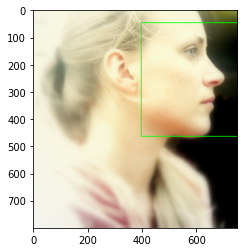

Speed: 17.54ms
Precision: 1.0
Recall: 0.3333333333333333
Ious: [0.8086774699424987]
Positives: 1, False Positives: 0, Negatives: 2


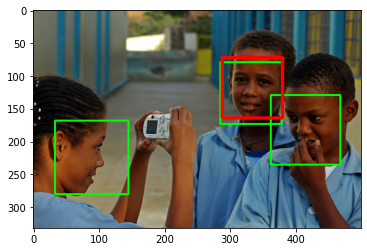

Speed: 11.5022ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


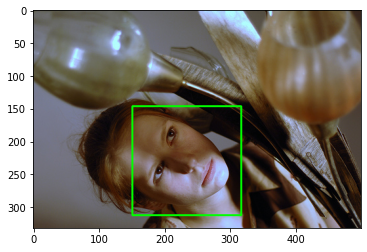

Speed: 21.3919ms
Precision: 0.0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 1, Negatives: 1


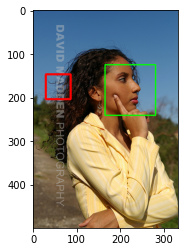

Speed: 147.4553ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


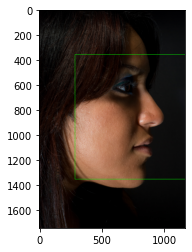

Speed: 35.6513ms
Precision: 0.0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 1, Negatives: 1


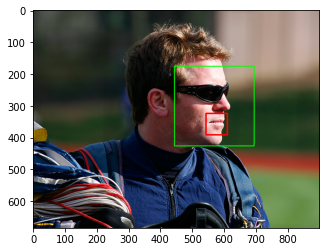

Speed: 36.7814ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


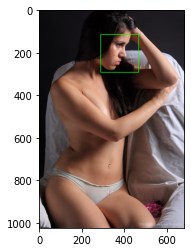

Speed: 62.2688ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


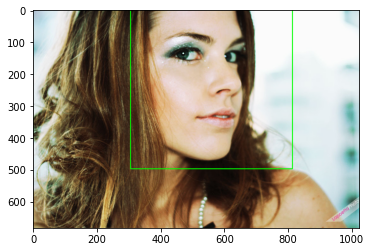

Speed: 20.7993ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


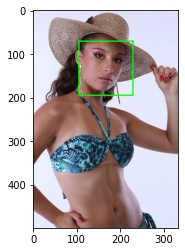

Speed: 29.1531ms
Precision: 1.0
Recall: 1.0
Ious: [0.65014396813864, 0.7788908200347606]
Positives: 2, False Positives: 0, Negatives: 0


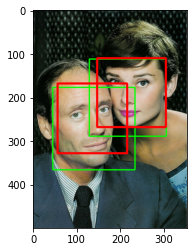

Speed: 15.0842ms
Precision: 0
Recall: 0.0
Ious: []
Positives: 0, False Positives: 0, Negatives: 1


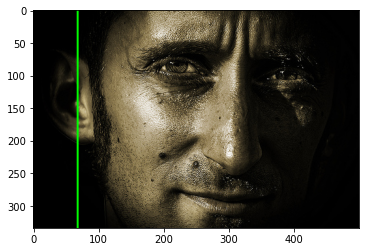

In [4]:
for face_image in load_aflw(30):
    box_id = 0
    img = cv2.imread(face_image.image_path)
    for face in face_image.faces:
        b = face.box
        cv2.rectangle(img, (b.x1, b.y1), (b.x2, b.y2), (0, 255, 0), 2)
        
    t1_start = perf_counter_ns()
    faces = face_classifier.detectMultiScale(
            img,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
    t1_stop = perf_counter_ns()
    
    boxes = []
    for f in faces:
        boxes.append(Box(box_id = box_id, x1 = f[0], y1 = f[1], w = f[2], h = f[3]))
        box_id += 1
    
    acc = face_image.calculate_prediction(boxes)
    acc.stats()
    
    pred = Prediction(t1_stop-t1_start, acc)
    print(pred.stats())

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 3)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()